In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from nltk.translate.bleu_score import sentence_bleu
import random

In [6]:
# 1. Load the dataset
df = pd.read_excel('/content/tamildataset.xlsx')

# Display the first few rows
df.head()


,Serial Number,Error Type,Ungrammatical Statement,Standard Tamil
0,0,error1,நான் நேற்று பாடம் படிக்கிறேன்.,நான் நேற்று பாடம் படித்தேன்.
1,1,error2,அவள் பள்ளிக்குச் சென்றான்.,அவள் பள்ளிக்குச் சென்றாள்.
2,2,error1,நான் நேற்று தோசை சாப்பிடுகிறேன்.,நான் நேற்று தோசை சாப்பிட்டேன்.
3,3,error1,அவன் இப்போது பள்ளிக்குச் சென்றான்.,அவன் இப்போது பள்ளிக்குச் செல்கிறான்.
4,4,error2,அவன் உணவு சாப்பிட்டாள்.,அவன் உணவு சாப்பிட்டான்.


In [8]:
# Clean dataset to handle missing or unexpected values
df = df.dropna(subset=['Ungrammatical Statement', 'Standard Tamil'])
df['Ungrammatical Statement'] = df['Ungrammatical Statement'].astype(str)
df['Standard Tamil'] = df['Standard Tamil'].astype(str)

# Separate the ungrammatical statements and standard Tamil sentences
input_sentences = df['Ungrammatical Statement'].values
target_sentences = ['<start> ' + sentence + ' <end>' for sentence in df['Standard Tamil'].values]


<ipython-input-8-fbde7730036d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Ungrammatical Statement'] = df['Ungrammatical Statement'].astype(str)
<ipython-input-8-fbde7730036d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Standard Tamil'] = df['Standard Tamil'].astype(str)


In [9]:
# Tokenize the input and target sentences
input_tokenizer = Tokenizer(filters='')
input_tokenizer.fit_on_texts(input_sentences)
input_sequences = input_tokenizer.texts_to_sequences(input_sentences)

output_tokenizer = Tokenizer(filters='')
output_tokenizer.fit_on_texts(target_sentences)
target_sequences = output_tokenizer.texts_to_sequences(target_sentences)

In [10]:
# Find the maximum sequence lengths
max_input_length = max(len(seq) for seq in input_sequences)
max_target_length = max(len(seq) for seq in target_sequences)

# Pad sequences to ensure equal length
encoder_input_data = pad_sequences(input_sequences, maxlen=max_input_length, padding='post')
decoder_input_data = pad_sequences(target_sequences, maxlen=max_target_length, padding='post')

# Prepare decoder output data (shifted by 1 position)
decoder_output_data = np.zeros((len(target_sequences), max_target_length, len(output_tokenizer.word_index) + 1), dtype='float32')
for i, seq in enumerate(target_sequences):
    for t, word_id in enumerate(seq):
        if t > 0:  # Skip the first token (start token)
            decoder_output_data[i, t - 1, word_id] = 1.0


In [11]:
# Train-Test Split
encoder_input_train, encoder_input_val, decoder_input_train, decoder_input_val, decoder_output_train, decoder_output_val = train_test_split(
    encoder_input_data, decoder_input_data, decoder_output_data, test_size=0.2, random_state=42)


In [12]:
# Build the Seq2Seq Model
embedding_dim = 256
hidden_units = 512

# Encoder
encoder_inputs = Input(shape=(max_input_length,))
encoder_embedding = Embedding(input_dim=len(input_tokenizer.word_index) + 1, output_dim=embedding_dim)(encoder_inputs)
encoder_lstm = LSTM(hidden_units, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_target_length,))
decoder_embedding = Embedding(input_dim=len(output_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(len(output_tokenizer.word_index) + 1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [13]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
batch_size = 64
epochs = 50
history = model.fit(
    [encoder_input_train, decoder_input_train],
    decoder_output_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([encoder_input_val, decoder_input_val], decoder_output_val)
)

Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 456ms/step - accuracy: 0.1041 - loss: 2.9034 - val_accuracy: 0.1941 - val_loss: 2.9385
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.1611 - loss: 2.7442 - val_accuracy: 0.1429 - val_loss: 2.4482
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.1429 - loss: 2.2925 - val_accuracy: 0.1502 - val_loss: 2.3812
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.1696 - loss: 2.1876 - val_accuracy: 0.2198 - val_loss: 2.1442
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 241ms/step - accuracy: 0.2081 - loss: 1.9877 - val_accuracy: 0.2198 - val_loss: 2.0712
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step - accuracy: 0.2109 - loss: 1.8740 - val_accuracy: 0.2564 - val_loss: 1.8883
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 239ms/step - accuracy: 0.2683 - loss: 1.6766 - val_accuracy: 0.2711 - val_loss: 1.7834
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step - accuracy: 0.2807 - loss: 1.5866 - val_accuracy: 0.2784 - val_loss:

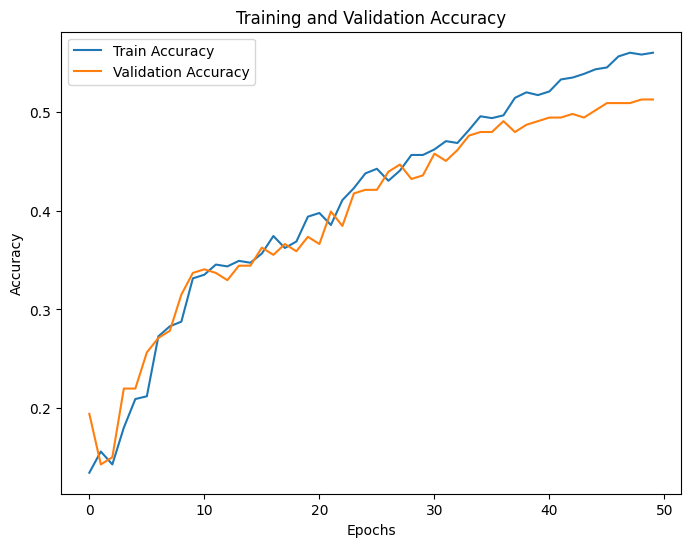

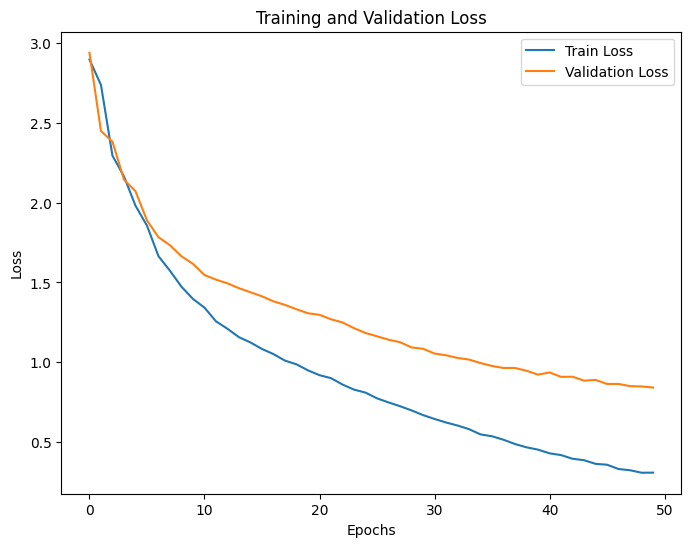

In [14]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [15]:
# Inference
encoder_model = Model(encoder_inputs, encoder_states)
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_embedding_inf = Embedding(input_dim=len(output_tokenizer.word_index) + 1, output_dim=embedding_dim)(decoder_inputs)
decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding_inf, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

In [16]:
def decode_sequence(input_seq):
    states_value = encoder_model.predict(input_seq)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = output_tokenizer.word_index['<start>']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = None
        for word, index in output_tokenizer.word_index.items():
            if index == sampled_token_index:
                sampled_word = word
                break
        if sampled_word == '<end>' or len(decoded_sentence.split()) > max_target_length:
            stop_condition = True
        else:
            decoded_sentence += ' ' + sampled_word
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index
        states_value = [h, c]
    return decoded_sentence.strip()

In [17]:
# Test the model with random sentences
random_indices = random.sample(range(len(input_sentences)), 5)
selected_test_inputs = [input_sentences[i] for i in random_indices]
selected_test_targets = [target_sentences[i] for i in random_indices]
predictions = []
references = []
for input_sentence, target_sentence in zip(selected_test_inputs, selected_test_targets):
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions.append(predicted_sentence.split())
    references.append([target_sentence.split()])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [18]:
# Test the model with random sentences
random_indices = random.sample(range(len(input_sentences)), 5)
selected_test_inputs = [input_sentences[i] for i in random_indices]
selected_test_targets = [target_sentences[i] for i in random_indices]
predictions = []
references = []
for input_sentence, target_sentence in zip(selected_test_inputs, selected_test_targets):
    input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')
    predicted_sentence = decode_sequence(input_seq)
    predictions.append(predicted_sentence.split())
    references.append([target_sentence.split()])

# Calculate BLEU Scores for the selected sentences
bleu_scores = [sentence_bleu(ref, pred, weights=(0.5, 0.5)) for pred, ref in zip(predictions, references)]

# Compute the average BLEU score
avg_bleu_score = sum(bleu_scores) / len(bleu_scores)

# Display BLEU scores
for i, score in enumerate(bleu_scores):
    print(f"Sentence {i+1} BLEU Score: {score:.4f}")
print(f"Average BLEU Score for 5 sentences: {avg_bleu_score:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Sentence 1 BLEU Score: 0.3679
Sentence 2 BLEU Score: 0.3679
Sentence 3 BLEU Score: 0.2231
Sentence 4 BLEU Score: 0.2231
Senten

In [19]:
# Define the ungrammatical input sentence
input_sentence = "நான் நேற்று பாடம் படிக்கிறேன்."  # Example ungrammatical sentence

# Preprocess the input sentence
input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')

# Get the predicted sentence using the model
predicted_sentence = decode_sequence(input_seq)

# Output the result
print("Input Sentence (Ungrammatical):", input_sentence)
print("Predicted Sentence (Grammatical):", predicted_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Input Sentence (Ungrammatical): நான் நேற்று பாடம் படிக்கிறேன்.
Predicted Sentence (Grammatical): நான் நேற்று பாடம் படித்தேன்.


In [22]:
# Define the ungrammatical input sentence
input_sentence = "அவள் பாடம் படித்தான்."  # Example ungrammatical sentence

# Preprocess the input sentence
input_seq = pad_sequences(input_tokenizer.texts_to_sequences([input_sentence]), maxlen=max_input_length, padding='post')

# Get the predicted sentence using the model
predicted_sentence = decode_sequence(input_seq)

# Output the result
print("Input Sentence (Ungrammatical):", input_sentence)
print("Predicted Sentence (Grammatical):", predicted_sentence)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Input Sentence (Ungrammatical): அவள் பாடம் படித்தான்.
Predicted Sentence (Grammatical): அவள் பாடம் படித்தாள்.
